In [1]:
import pandas as pd
import numpy as np
import kagglehub

from kagglehub import KaggleDatasetAdapter

# Sklearn for splitting data
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import KFold # for cross-validation

Loading data from Kaggle using `kagglehub`

In [2]:
file_path = "House_Rent_Dataset.csv"

df_base = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "iamsouravbanerjee/house-rent-prediction-dataset",
  file_path
)

/tmp/ipykernel_7824/2526117203.py:3: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df_base = kagglehub.load_dataset(


In [3]:
df_base.head()

,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
0,2022-05-18,2,10000,1100,Ground out of 2,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner
1,2022-05-13,2,20000,800,1 out of 3,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
2,2022-05-16,2,17000,1000,1 out of 3,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
3,2022-07-04,2,10000,800,1 out of 2,Super Area,Dumdum Park,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner
4,2022-05-09,2,7500,850,1 out of 2,Carpet Area,South Dum Dum,Kolkata,Unfurnished,Bachelors,1,Contact Owner


In [4]:
df_base.shape

(4746, 12)

In [5]:
df_base.dtypes

Posted On            object
BHK                   int64
Rent                  int64
Size                  int64
Floor                object
Area Type            object
Area Locality        object
City                 object
Furnishing Status    object
Tenant Preferred     object
Bathroom              int64
Point of Contact     object
dtype: object

In [6]:
df_base.columns

Index(['Posted On', 'BHK', 'Rent', 'Size', 'Floor', 'Area Type',
       'Area Locality', 'City', 'Furnishing Status', 'Tenant Preferred',
       'Bathroom', 'Point of Contact'],
      dtype='object')

In [7]:
df_base.columns = df_base.columns.str.lower().str.replace(' ', '_')

In [8]:
df = df_base.drop(columns=["floor", 'area_locality', "posted_on"])

In [9]:
strings = list(df.dtypes[df.dtypes == 'object'].index)

In [10]:
for col in strings:
    df[col] = df[col].str.lower().str.replace(' ', '_') 

In [11]:
for col in df.columns:
    print(col)
    print(df[col].unique()[:5])
    print(df[col].nunique())
    print()

bhk
[2 1 3 6 4]
6

rent
[10000 20000 17000  7500  7000]
243

size
[1100  800 1000  850  600]
615

area_type
['super_area' 'carpet_area' 'built_area']
3

city
['kolkata' 'mumbai' 'bangalore' 'delhi' 'chennai']
6

furnishing_status
['unfurnished' 'semi-furnished' 'furnished']
3

tenant_preferred
['bachelors/family' 'bachelors' 'family']
3

bathroom
[2 1 3 5 4]
8

point_of_contact
['contact_owner' 'contact_agent' 'contact_builder']
3



In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

<Axes: xlabel='rent', ylabel='Count'>

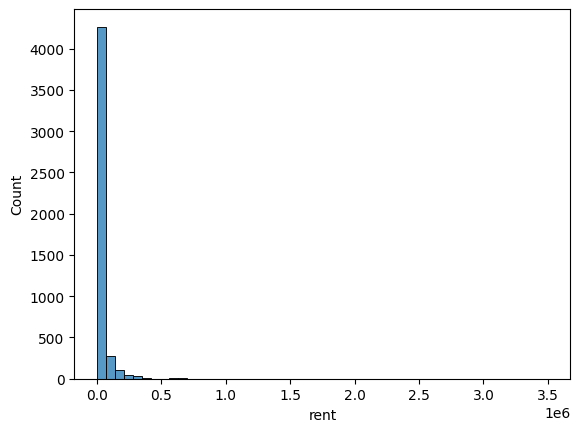

In [13]:
sns.histplot(df.rent, bins=50)

<Axes: xlabel='rent', ylabel='Count'>

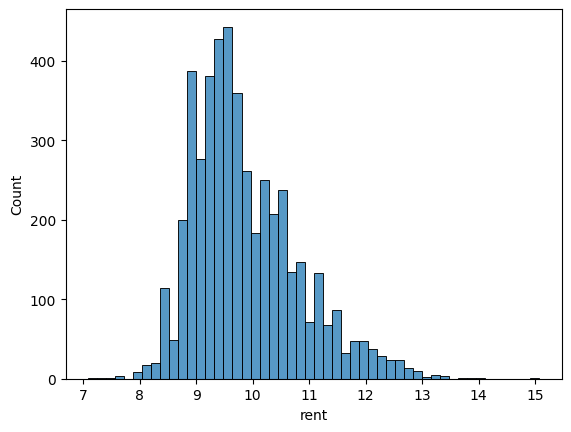

In [14]:
rent_logs = np.log1p(df.rent)
sns.histplot(rent_logs, bins=50)

Missing Values

In [15]:
df.isnull().sum()

bhk                  0
rent                 0
size                 0
area_type            0
city                 0
furnishing_status    0
tenant_preferred     0
bathroom             0
point_of_contact     0
dtype: int64

In [16]:
df.describe().round(2)

,bhk,rent,size,bathroom
count,4746.00,4746.00,4746.00,4746.00
mean,2.08,34993.45,967.49,1.97
std,0.83,78106.41,634.20,0.88
min,1.00,1200.00,10.00,1.00
25%,2.00,10000.00,550.00,1.00
50%,2.00,16000.00,850.00,2.00
75%,3.00,33000.00,1200.00,2.00
max,6.00,3500000.00,8000.00,10.00


Spliting data

In [17]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = np.log1p(df_train.rent.values)
y_val = np.log1p(df_val.rent.values)
y_test = np.log1p(df_test.rent.values)

del df_train['rent']
del df_val['rent']
del df_test['rent']

In [18]:
len(df_train), len(df_val), len(df_test)

(2847, 949, 950)

In [19]:
# Numerical columns (contain numeric values)
numerical = [
    'bhk',        # Number of Bedrooms, Hall, Kitchen
    'size',       # Size of the property in square feet
    'bathroom'    # Number of bathrooms
]

# Categorical columns (contain text or descriptive values)
categorical = [
    'area_type',         # Super Area / Carpet Area / Build Area
    'city',              # City where the property is located
    'furnishing_status', # Furnished / Semi-Furnished / Unfurnished
    'tenant_preferred',  # Type of tenant preferred
    'point_of_contact'   # Who to contact for more information
]

In [55]:
df_train.iloc[10]

bhk                              1
size                           600
area_type              carpet_area
city                     bangalore
furnishing_status      unfurnished
tenant_preferred         bachelors
bathroom                         2
point_of_contact     contact_owner
Name: 10, dtype: object

In [21]:
from sklearn.feature_extraction import DictVectorizer

In [22]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

In [29]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score

In [24]:
model_lr = LinearRegression()

In [25]:
model_lr.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [26]:
y_pred = model_lr.predict(X_val)

In [27]:
rmse = root_mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

rmse, r2

(0.3829834233686093, 0.8266586306011079)

In [45]:
from sklearn.linear_model import Ridge

model = Ridge(alpha=1.0)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_val_scaled)

In [46]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

param_grid = {
    "alpha": [0.01, 0.1, 1.0, 10.0, 100.0]  # różne poziomy regularizacji
}

grid = GridSearchCV(
    Ridge(),
    param_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)

grid.fit(X_train_scaled, y_train)

print("Best alpha:", grid.best_params_["alpha"])
print("Best CV RMSE:", -grid.best_score_)

best_ridge = grid.best_estimator_
y_pred = best_ridge.predict(X_val_scaled)
rmse_val = np.sqrt(mean_squared_error(y_val, y_pred))
print("RMSE on validation:", rmse_val)

Best alpha: 10.0
Best CV RMSE: 0.41375103557194093
RMSE on validation: 0.38298995205917447


<Axes: ylabel='Count'>

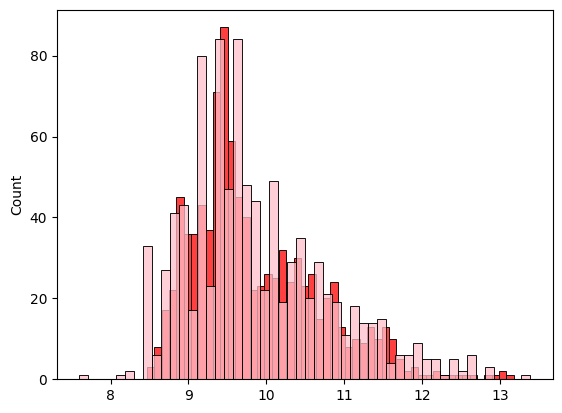

In [28]:
sns.histplot(y_pred, color='red', bins=50)
sns.histplot(y_val, color='pink', bins=50)

In [31]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

In [32]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

In [33]:
scores = []

In [34]:
for train_idx, val_idx in kfold.split(df_full_train):
    df_tr = df_full_train.iloc[train_idx]
    df_v = df_full_train.iloc[val_idx]

    y_tr = np.log1p(df_tr.rent.values)
    y_v = np.log1p(df_v.rent.values)

    train_dict = df_tr[categorical + numerical].to_dict(orient='records')
    val_dict   = df_v[categorical + numerical].to_dict(orient='records')

    X_tr = dv.fit_transform(train_dict)
    X_v  = dv.transform(val_dict)

    model = Ridge(alpha=1.0)
    model.fit(X_tr, y_tr)
    pred = model.predict(X_v)

    rmse = np.sqrt(mean_squared_error(y_v, pred))
    scores.append(rmse)

print("CV RMSE:", np.mean(scores))

CV RMSE: 0.4062793347562626


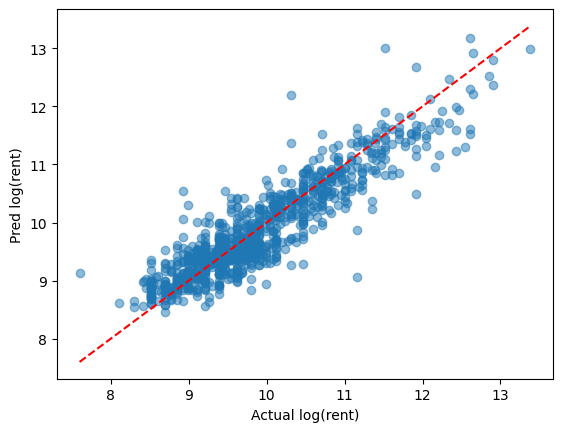

In [35]:
plt.scatter(y_val, y_pred, alpha=0.5)
plt.xlabel("Actual log(rent)")
plt.ylabel("Pred log(rent)")
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], "r--")

 DecisionTreeRegressor

In [36]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [53]:
model_dt = DecisionTreeRegressor(
    random_state=1, 
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=5,
    max_features=None
)

In [38]:
model_dt.fit(X_train, y_train)

,criterion,'squared_error'
,splitter,'best'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,1
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [39]:
y_pred_dt = model_dt.predict(X_val)

In [40]:
rmse_dt = np.sqrt(mean_squared_error(y_val, y_pred_dt))
r2_dt = r2_score(y_val, y_pred_dt)

In [41]:
print("Decision Tree RMSE:", rmse_dt, "R²:", r2_dt)

Decision Tree RMSE: 0.41563058350207244 R²: 0.7958462962445876


In [42]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "max_depth": [5, 10, 15, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5],
    "max_features": ['sqrt', None]
}

grid_search = GridSearchCV(
    DecisionTreeRegressor(random_state=1),
    param_grid,
    scoring='neg_root_mean_squared_error',
    cv=5,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
print("Best params:", grid_search.best_params_)
print("Best CV RMSE:", -grid_search.best_score_)

Best params: {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 2}
Best CV RMSE: 0.4325373500515942


In [48]:
model_rf = RandomForestRegressor(
    random_state=1, 
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=5,
    max_features=None
)

In [50]:
model_rf.fit(X_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0
,max_features,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [51]:
importances = model_rf.feature_importances_
feature_names = dv.get_feature_names_out()
sorted_idx = np.argsort(importances)[::-1]

for i in sorted_idx[:10]:
    print(feature_names[i], importances[i])


point_of_contact=contact_agent 0.39650455091885456
bathroom 0.25812760281491753
size 0.13745317071666588
city=mumbai 0.10995924927321894
point_of_contact=contact_owner 0.027235405929037778
bhk 0.021003350628687443
furnishing_status=unfurnished 0.008191512492488565
furnishing_status=furnished 0.00791487558159951
city=delhi 0.007497663717874718
city=kolkata 0.00700723030025781


RandomForestRegressor

In [52]:
model_rf = RandomForestRegressor(
    n_estimators=200, 
    max_depth=10, 
    min_samples_split=10, 
    min_samples_leaf=1,
    max_features=None,
    random_state=1,
    n_jobs=-1
)


In [ ]:
model_rf.fit(X_train, y_train)

,n_estimators,200
,criterion,'squared_error'
,max_depth,15
,min_samples_split,10
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [ ]:
y_pred_rf = model_rf.predict(X_val)

In [ ]:
rmse_rf = np.sqrt(mean_squared_error(y_val, y_pred_rf))
r2_rf = r2_score(y_val, y_pred_rf)

In [ ]:
print("Random Forest RMSE:", rmse_rf, "R²:", r2_rf)

Random Forest RMSE: 0.38649897799497224 R²: 0.8234616882000543


In [ ]:
param_grid = {
    "max_depth": [5, 10, 15, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5],
    "max_features": ['sqrt', None]
}

grid_search = GridSearchCV(
    RandomForestRegressor(random_state=1),
    param_grid,
    scoring='neg_root_mean_squared_error',
    cv=5,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
print("Best params:", grid_search.best_params_)
print("Best CV RMSE:", -grid_search.best_score_)

Best params: {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 10}
Best CV RMSE: 0.4040595473430605


                       RMSE        R2
Linear Regression  0.382983  0.826659
Random Forest      0.386499  0.823462
Decision Tree      0.415631  0.795846
Ridge              1.573809 -1.927161


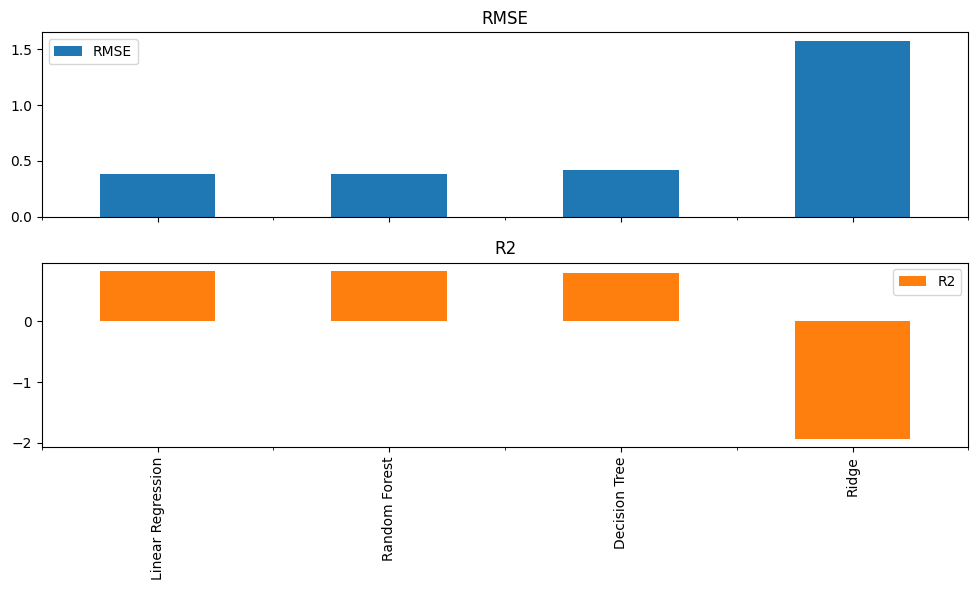

In [ ]:
results = {}

# Linear Regression
y_pred_lr = model_lr.predict(X_val)
results['Linear Regression'] = {
    'RMSE': np.sqrt(mean_squared_error(y_val, y_pred_lr)),
    'R2': r2_score(y_val, y_pred_lr)
}

# Ridge
y_pred_ridge = model.predict(X_val_scaled)
results['Ridge'] = {
    'RMSE': np.sqrt(mean_squared_error(y_val, y_pred_ridge)),
    'R2': r2_score(y_val, y_pred_ridge)
}

# Decision Tree
y_pred_dt = model_dt.predict(X_val)
results['Decision Tree'] = {
    'RMSE': np.sqrt(mean_squared_error(y_val, y_pred_dt)),
    'R2': r2_score(y_val, y_pred_dt)
}

# Random Forest
y_pred_rf = model_rf.predict(X_val)
results['Random Forest'] = {
    'RMSE': np.sqrt(mean_squared_error(y_val, y_pred_rf)),
    'R2': r2_score(y_val, y_pred_rf)
}

df_results = pd.DataFrame(results).T.sort_values(by='RMSE')
print(df_results)

import matplotlib.pyplot as plt

df_results.plot(kind='bar', y=['RMSE','R2'], subplots=True, figsize=(10,6), legend=True)
plt.tight_layout()

In [44]:
import pickle

In [54]:
output_file = 'model.bin'

In [56]:
with open(output_file, 'wb') as f_out:
    pickle.dump((dv, model), f_out)